## Equivariant Convolutions from paper [Group Equivariant Convolutional Networks](https://arxiv.org/abs/1602.07576)
---

A map $f$ is **equivariant** to the group of transformations $G$, if 
the action of symmetry by $g \in G$ on input domain implies action of a symmetry on the output domain. 
$$
f(\mathbb{T}_g x) = \mathbb{T}_g^{'} f(x)
$$
if $ \mathbb{T}_g^{'} = \mathrm{id}$ $f$ is an **invariant** map. 

**G-Equivariant convolution**

Convolution (cross-correlation) with some arbitrary group $G$ is defined as follows:
$$
[f \star h] (g) = 
\sum_{u \in G} f (g) h(T_{u^{-1}} g)
$$
Contrary to the standard convolution on $\mathbb{R}^{n}$ signals are now functions on $G$, i.e:
$f : G \rightarrow  R^{m}$ for some $m$. 

G-Equivariant convolution satisfies the equivariance property:
$$
[[T_{u} f \star h]](g) = [T_{u}[f \star h](g)]
$$

In what follows, we consider $G$ to be the *semidirect* product of 2d group of translations $\mathbb{Z}^{2}$
and some other discrete group.

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

We are going to consider following discrete groups:
* $Z_2$ - reflections along the axis

There are 2 elements: $e$ and $h$, such that $h^2=e$

* $P_4$ - rotations by $\pi k / 2, k \in \mathbb{Z}$ (isomorphic to cyclic $\mathbb{Z}_4$)

There are 4 elements $\sim e^{\pi k i / 4}$

* $P_{4m}$ - rotations by $\pi k / 2, k \in \mathbb{Z}$ with reflections

There are 8 elements $\sim e^{\pi k i / 4}, h e^{\pi k i / 4}$. 

Note, the latter group in non-commutative.

In [3]:
from src.groups.transforms import (
    identity,  
    rotate90, 
    rotate180, 
    rotate270, 
    hflip,
    rotate90_hflip, 
    rotate180_hflip, 
    rotate270_hflip
)

In [4]:
from src.groups import (
    DiscreteGroup, Z2, P4, P4m
)

### Some examples

$Z_2$

In [5]:
g1 = Z2(1)
g2 = Z2(1)

print(f"g1: {g1}, g2: {g2}, g1*g2: {g1 * g2}")

g1: s, g2: s, g1*g2: e


$P_4$

In [6]:
g1 = P4(1)
g2 = P4(2)

print(f"g1: {g1}, g2: {g2}, g1*g2: {g1 * g2}")

g1: r^1, g2: r^2, g1*g2: r^3


$P_{4m}$

In [7]:
g1 = P4m(1, 1)
g2 = P4m(2, 1)

print(f"g1: {g1}, g2: {g2}, g1*g2: {g1 * g2}")

g1: r^1 s, g2: r^2 s, g1*g2: r^3 


## Illustrate transforms
---

In [8]:
from PIL import Image

In [9]:
IMAGE_SIZE = 256

image = Image.open("images/naruto.png").convert('RGB')
# resize image
image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
# convert to image
image = np.array(image) / 255.0
# convert to tensor
image = torch.FloatTensor(image)

### $\mathbb{Z_2}$ case

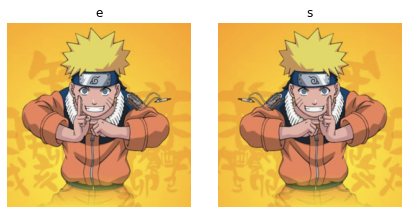

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

for i, transform in enumerate(Z2.transforms):
    transformed_image = transform(image.permute(2, 0, 1)).permute(1, 2, 0)
    ax[i].imshow(transformed_image)
    ax[i].set_title(Z2(i))
    ax[i].axis('off');
    
plt.tight_layout()

### $\mathbb{P_4}$ case

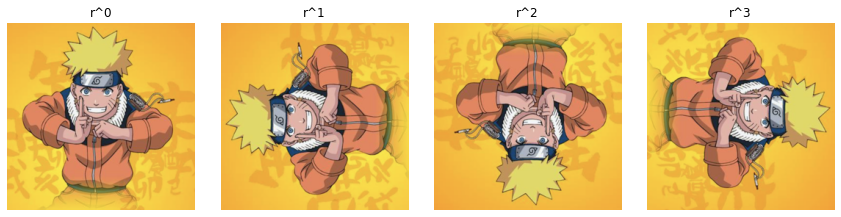

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

for i, transform in enumerate(P4.transforms):
    transformed_image = transform(image.permute(2, 0, 1)).permute(1, 2, 0)
    ax[i].imshow(transformed_image)
    ax[i].set_title(P4(i))
    ax[i].axis('off');
    
plt.tight_layout()

### $\mathbb{P_{4m}}$ case

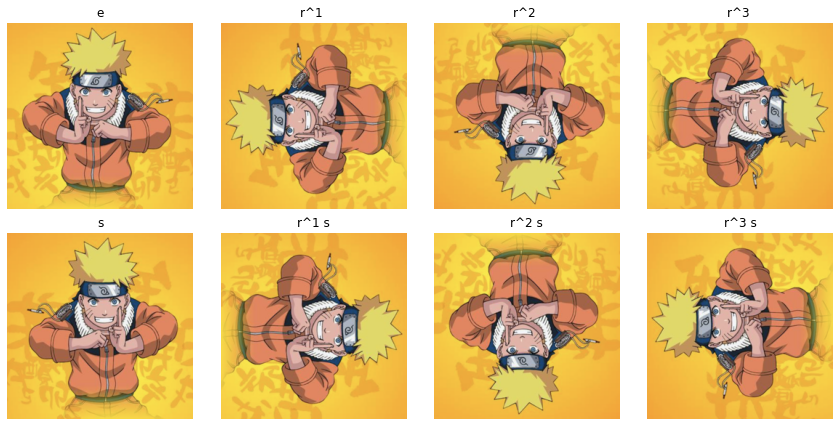

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for idx, transform in enumerate(P4m.transforms):
    i, j = idx // 4, idx % 4
    transformed_image = transform(image.permute(2, 0, 1)).permute(1, 2, 0)
    ax[i, j].imshow(transformed_image)
    ax[i, j].set_title(P4m(j, i))
    ax[i, j].axis('off');
    
plt.tight_layout()

## Group Equivariant convolution
---

In the paper by [Cohen&Welling](https://arxiv.org/abs/1602.07576) **equivariance** under the action of discrete group $G$ is achieved in the following way

In [14]:
from src.modules import GConv2d

### Non-equivariant (under $R_4$) convolution
---

Let us first illustrate action of the $R_4$ non-equivariant convolution on the original image

In [17]:
# take the original image
x0 = image.permute(2, 0, 1)[None, :] 

In [18]:
conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)

with torch.no_grad():
    for i in range(3):
        # Sobel filter
        conv.weight[0, i] = torch.FloatTensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [19]:
with torch.no_grad():
    x_out_0 = conv(x0)[0, 0]
    x_out_r = conv(rotate90(x0))[0, 0]

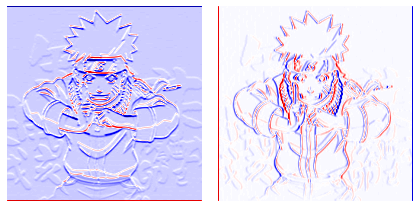

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax[0].imshow(x_out_0, cmap='seismic')
ax[0].axis('off')

ax[1].imshow(rotate270(x_out_r), cmap='seismic')
ax[1].axis('off')

plt.tight_layout()

Consider the relative difference

In [21]:
print(f"std of [W * rx - r^(-1) W * x]: {(x_out_0 - rotate270(x_out_r)).std().item():.3f}")
print(f"W * x: {x_out_0.mean().item():.3f} +- {x_out_0.std().item():.3f}")

std of [W * rx - r^(-1) W * x]: 1.654
W * x: -0.010 +- 1.164


It is of the order of the signal value.

Ordinary convolution <span style="color:red">is not</span> rotation-equivariant.

### G-equivariant convolution
---

In [22]:
# create convolution with 1 input channels and that returns equivariant representation
gconv = GConv2d(
    group=P4,
    in_channels=3, 
    in_repr=1,
    out_channels=1, 
    out_repr=4,
    kernel_size=3, 
    stride=1,
    padding=1
)

with torch.no_grad():
    for i in range(3):
        # Sobel filter
        gconv.weight[0, i, 0] = torch.FloatTensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [23]:
# here we add additional representation axis on 2nd place
x0 = image.permute(2, 0, 1)[None, :, None, :] 

### Convolution with original image

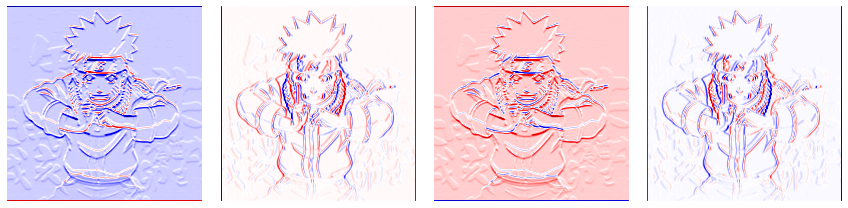

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

with torch.no_grad():
    x_out_0 = gconv(x0)
    for i in range(4):
        ax[i].imshow(x_out_0[0, 0, i], cmap='seismic')
        ax[i].axis('off')

plt.tight_layout()

### Convolution with rotated image
---

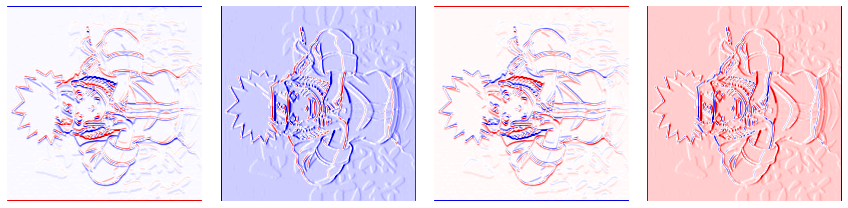

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

with torch.no_grad():
    x_out_r = gconv(rotate90(x0))
    for i in range(4):
        ax[i].imshow(x_out_r[0, 0, i], cmap='seismic')
        ax[i].axis('off')

plt.tight_layout()

Note, that the output of the convolution operation with the rotated input is the output of the the convolutional operation with the original image but with **cyclic shift** of the channel order and the feature map rotated by the same angle. 

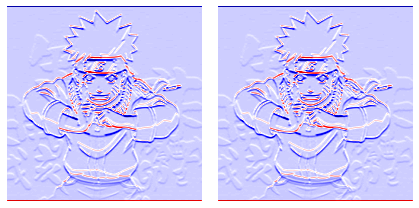

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax[0].imshow(x_out_0[0, 0, 0], cmap='seismic')
ax[0].axis('off')

ax[1].imshow(rotate270(x_out_r[0, 0, 1]), cmap='seismic')
ax[1].axis('off')

plt.tight_layout()

In [27]:
# subtract the 
print(f"std of [W * rx - r^(-1) W * x]: {(x_out_0[:, 0, 0] - rotate270(x_out_r[:, 0, 1])).std().item():.3f}")
print(f"W * x: {x_out_0.mean().item():.3f} +- {x_out_0.std().item():.3f}")

std of [W * rx - r^(-1) W * x]: 0.000
W * x: 0.134 +- 1.172


### Run on Rotated MNIST
---

A popular benchmark for evaluation of rotationally equivariant architectures is *Rotated MNIST* dataset, 
introduced in [Larochelle et.al.](https://dl.acm.org/doi/10.1145/1273496.1273556).

In [28]:
import os
import subprocess
# torch imports
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

In [27]:
# download and extract the data
mnist_path = "./data/rotated_mnist.zip"

if not os.path.exists(mnist_path):
    subprocess.call("curl http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip --output data/rotated_mnist.zip", shell=True)

!unzip data/rotated_mnist.zip -d data
!rm data/rotated_mnist.zip

In [29]:
MNIST_IMG_SIZE = 28

train_data = np.loadtxt('./data/mnist_all_rotation_normalized_float_train_valid.amat')
test_data = np.loadtxt('./data/mnist_all_rotation_normalized_float_test.amat')
# get images and labels
X_train = torch.from_numpy(train_data[:, :-1]).float().reshape(
    (len(train_data), MNIST_IMG_SIZE, MNIST_IMG_SIZE)
)
y_train = torch.from_numpy(train_data[:, -1]).long()
X_test = torch.from_numpy(test_data[:, :-1]).float().reshape(
    (len(test_data), MNIST_IMG_SIZE, MNIST_IMG_SIZE)
)
y_test = torch.from_numpy(test_data[:, -1]).long()

Dataset has <span style="color:red">*12000*</span> train samples and <span style="color:blue">*50000*</span> test samples of size $28 \times 28$

In [30]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  torch.Size([12000, 28, 28])
X_test:  torch.Size([50000, 28, 28])


Let us visualize some samples from the train dataset:

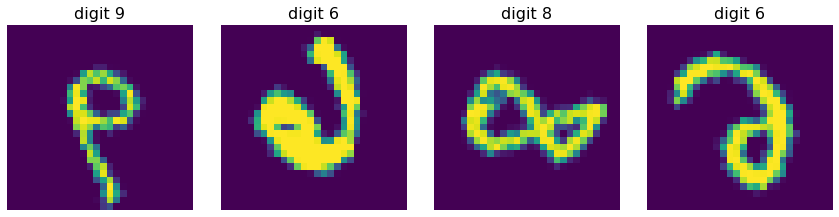

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

idxs = np.random.randint(0, len(X_train), size=4)

for i, idx in enumerate(idxs):
    ax[i].set_title(f"digit {y_train[idx]}", fontsize=16)
    ax[i].imshow(X_train[idx])
    ax[i].axis('off')

plt.tight_layout()

Prepare transforms (no augmentations):

In [32]:
mean, std = X_train.mean().item(), X_train.std().item()

train_transforms = T.Compose([
    T.Normalize(mean=mean, std=std)
])

val_transforms = T.Compose([
    T.Normalize(mean=mean, std=std)
])

In [33]:
class ImageDatasetFromTensors(Dataset):
    
    def __init__(self, images: torch.Tensor, labels: torch.Tensor, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        # add dummy axis
        image = image.unsqueeze(0)
        if self.transforms:
            image = self.transforms(image)
        return image, label

In [45]:
train_dataset = ImageDatasetFromTensors(X_train, y_train, transforms=train_transforms)
val_dataset = ImageDatasetFromTensors(X_test, y_test, transforms=val_transforms)

In [46]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
from experiments.RotMNIST import Z2CNN, P4CNN, P4_Z2CNN

In [38]:
model = P4CNN(channels=10, batchnorm=True, dropout=0.0)

num_params = sum(param.numel() for param in model.parameters())
print(f"Model has {num_params} parameters")

Model has 24610 parameters


### Sanity check
---

Since we have a stack of rotationally **equivariant** layers and the last GConv performs 
rotation **invariant** aggregation output logits should be the same for original and rotated image. 

In [39]:
# load some image
sample_image, _ = train_dataset[0]
sample_image = sample_image[None, ...]

In [40]:
with torch.no_grad():
    for rotate in P4.transforms:
        logits = model(rotate(sample_image))
        print(logits)

tensor([[0.0000, 2.2487, 3.1534, 0.9772, 2.4960, 4.2362, 1.8381, 0.8195, 0.0000,
         2.6530]])
tensor([[0.0000, 2.2487, 3.1534, 0.9772, 2.4960, 4.2362, 1.8381, 0.8195, 0.0000,
         2.6530]])
tensor([[0.0000, 2.2487, 3.1534, 0.9772, 2.4960, 4.2362, 1.8381, 0.8195, 0.0000,
         2.6530]])
tensor([[0.0000, 2.2487, 3.1534, 0.9772, 2.4960, 4.2362, 1.8381, 0.8195, 0.0000,
         2.6530]])


### Training the Equivariant NN
---

In [41]:
from src.engine import train

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)

In [47]:
NUM_EPOCHS = 40

history = train(
    model,
    dataloaders={"train" : train_loader, "val" : val_loader},
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS, 
    device='cuda'
)

Epoch 0/39
----------
train Loss: 0.8211 Acc: 0.7356
  val Loss: 0.4628 Acc: 0.8381
Epoch 1/39
----------
train Loss: 0.4006 Acc: 0.8586
  val Loss: 0.4093 Acc: 0.8538
Epoch 2/39
----------
train Loss: 0.3545 Acc: 0.8712
  val Loss: 0.3426 Acc: 0.8725
Epoch 3/39
----------
train Loss: 0.3252 Acc: 0.8806
  val Loss: 0.3295 Acc: 0.8765
Epoch 4/39
----------
train Loss: 0.2987 Acc: 0.8846
  val Loss: 0.3499 Acc: 0.8714
Epoch 5/39
----------
train Loss: 0.2826 Acc: 0.8898
  val Loss: 0.3484 Acc: 0.8744
Epoch 6/39
----------
train Loss: 0.2655 Acc: 0.8933
  val Loss: 0.3384 Acc: 0.8757
Epoch 7/39
----------
train Loss: 0.0716 Acc: 0.9762
  val Loss: 0.1163 Acc: 0.9667
Epoch 8/39
----------
train Loss: 0.0312 Acc: 0.9906
  val Loss: 0.0986 Acc: 0.9712
Epoch 9/39
----------
train Loss: 0.0165 Acc: 0.9963
  val Loss: 0.0928 Acc: 0.9745
Epoch 10/39
----------
train Loss: 0.0096 Acc: 0.9980
  val Loss: 0.0967 Acc: 0.9735
Epoch 11/39
----------
train Loss: 0.0055 Acc: 0.9994
  val Loss: 0.0919 Ac

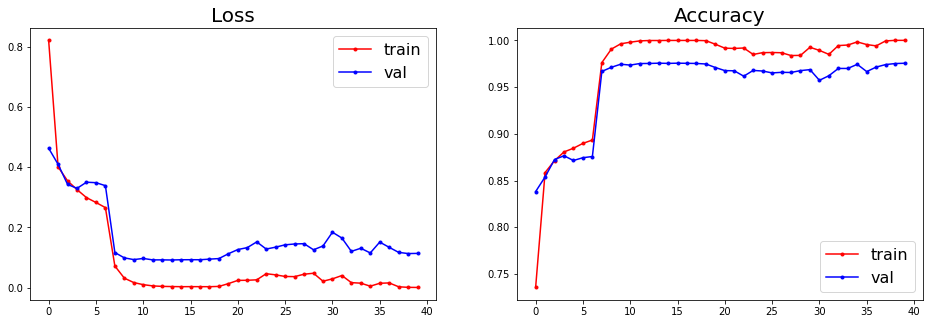

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax[0].set_title("Loss", fontsize=20)
ax[0].plot(history["train"]["loss"], '.-', label='train', color='red')
ax[0].plot(history["val"]["loss"], '.-', label='val', color='blue')
ax[0].legend(fontsize=16);

ax[1].set_title("Accuracy", fontsize=20)
ax[1].plot(history["train"]["acc"], '.-', label='train', color='red')
ax[1].plot(history["val"]["acc"], '.-', label='val', color='blue')
ax[1].legend(fontsize=16);

### Compare with Non-Equivariant
---

In [57]:
model = Z2CNN(channels=20, batchnorm=True, dropout=0.0)

num_params = sum(param.numel() for param in model.parameters())
print(f"Model has {num_params} parameters")

Model has 21620 parameters


In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)

In [59]:
NUM_EPOCHS = 40

history = train(
    model,
    dataloaders={"train" : train_loader, "val" : val_loader},
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS, 
    device='cuda'
)

Epoch 0/39
----------
train Loss: 1.1091 Acc: 0.6541
  val Loss: 0.7483 Acc: 0.7611
Epoch 1/39
----------
train Loss: 0.5771 Acc: 0.8123
  val Loss: 0.6406 Acc: 0.7903
Epoch 2/39
----------
train Loss: 0.5017 Acc: 0.8339
  val Loss: 0.4829 Acc: 0.8348
Epoch 3/39
----------
train Loss: 0.4364 Acc: 0.8486
  val Loss: 0.4780 Acc: 0.8325
Epoch 4/39
----------
train Loss: 0.3986 Acc: 0.8578
  val Loss: 0.4502 Acc: 0.8441
Epoch 5/39
----------
train Loss: 0.3771 Acc: 0.8641
  val Loss: 0.4298 Acc: 0.8489
Epoch 6/39
----------
train Loss: 0.3407 Acc: 0.8754
  val Loss: 0.4326 Acc: 0.8488
Epoch 7/39
----------
train Loss: 0.3221 Acc: 0.8794
  val Loss: 0.4402 Acc: 0.8466
Epoch 8/39
----------
train Loss: 0.2981 Acc: 0.8880
  val Loss: 0.3946 Acc: 0.8593
Epoch 9/39
----------
train Loss: 0.2776 Acc: 0.8943
  val Loss: 0.3902 Acc: 0.8616
Epoch 10/39
----------
train Loss: 0.2633 Acc: 0.8978
  val Loss: 0.3862 Acc: 0.8621
Epoch 11/39
----------
train Loss: 0.2533 Acc: 0.9007
  val Loss: 0.3894 Ac

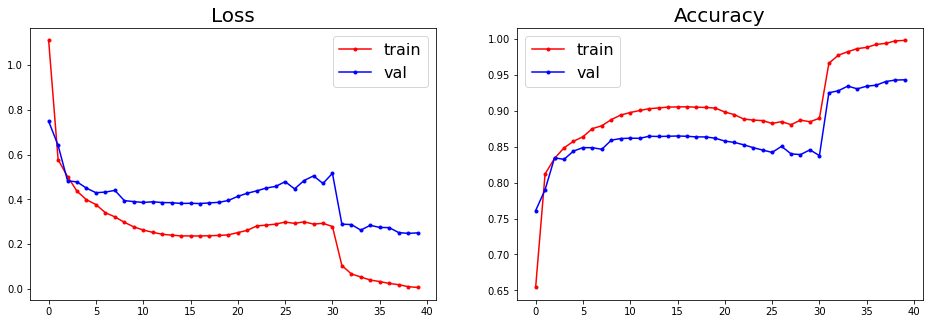

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax[0].set_title("Loss", fontsize=20)
ax[0].plot(history["train"]["loss"], '.-', label='train', color='red')
ax[0].plot(history["val"]["loss"], '.-', label='val', color='blue')
ax[0].legend(fontsize=16);

ax[1].set_title("Accuracy", fontsize=20)
ax[1].plot(history["train"]["acc"], '.-', label='train', color='red')
ax[1].plot(history["val"]["acc"], '.-', label='val', color='blue')
ax[1].legend(fontsize=16);

Training of CNN without equivariance is less stable, and the gap between train and test loss is larger.